In [1]:

import sys
sys.path.append("..")

from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

/home/martin/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
df = compile_team_tracking_data("../data", "Denmark")

In [3]:
corner = df.iloc[112512:112512+2]

In [4]:
generate_pitch_with_vectors(corner, "example_for_report_points")

In [5]:
ripleys_k_data = ripley_k_by_indices(corner,[112512])

In [6]:
ripleys_k_data = ripleys_k_data[0]

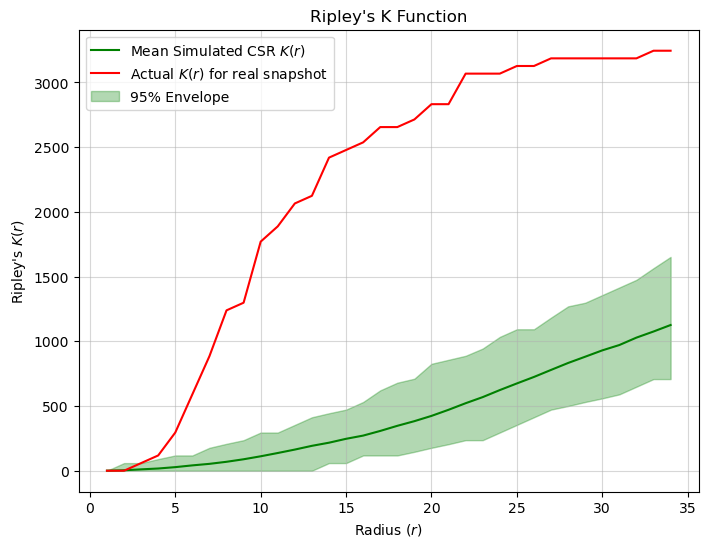

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Parameters for the area and number of points
num_points = 11  # Number of points for CSR
width, height = 52.5 - (-52.5), 34 - (-34)  # Area dimensions
area = width * height  # Total area
lambda_density = num_points / area  # Intensity (points per unit area)

# Define radii for which to calculate Ripley's K
radii = np.linspace(1, 34, 34)  # Radii from 1 to 34

# Function to generate random points uniformly in the area
def generate_random_points(num_points, width, height):
    x_coords = np.random.uniform(-width / 2, width / 2, num_points)
    y_coords = np.random.uniform(-height / 2, height / 2, num_points)
    return np.column_stack((x_coords, y_coords))

# Function to calculate Ripley's K
def ripley_k(points, radii, width, height):
    n = len(points)
    area = width * height
    lambda_density = n / area
    k_values = []
    
    # Compute pairwise distances
    distances = cdist(points, points)
    
    for r in radii:
        # Count pairs within distance r (ignoring self-pairs and duplicates)
        count = np.sum((distances < r) & (distances > 0)) / 2  # Avoid double counting
        k_r = count / (n * lambda_density)  # Adjust by intensity
        k_values.append(k_r)
    
    return k_values

# Running multiple simulations to create an envelope
n_simulations = 100  # Number of simulations
k_values_simulations = np.zeros((n_simulations, len(radii)))

# Running the simulations
for i in range(n_simulations):
    random_points = generate_random_points(num_points, width, height)
    k_values_simulations[i] = ripley_k(random_points, radii, width, height)

# Calculating the mean and the 95% envelope
k_mean = k_values_simulations.mean(axis=0)
k_upper = np.percentile(k_values_simulations, 97.5, axis=0)
k_lower = np.percentile(k_values_simulations, 2.5, axis=0)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(radii, k_mean, label="Mean Simulated CSR $K(r)$", color='green')
plt.plot(radii, ripleys_k_data, label="Actual $K(r)$ for real snapshot", color='red')
plt.fill_between(radii, k_lower, k_upper, color='green', alpha=0.3, label="95% Envelope")
plt.title("Ripley's K Function")
plt.xlabel("Radius ($r$)")
plt.ylabel("Ripley's $K(r)$")
plt.grid(alpha=0.5)
plt.legend()
plt.show()
